# Pull the fitted models

In [19]:
import sqlite3
import pandas as pd
import pickle

# Connect to the SQLite database
conn = sqlite3.connect('orlando.db')

# Query to pull observations where model='VAR'
query_var = "SELECT * FROM models WHERE model='VAR'"
df_var = pd.read_sql_query(query_var, conn)

# Query to pull observations where model='prophet'
query_prophet = "SELECT * FROM models WHERE model='prophet'"
df_prophet = pd.read_sql_query(query_prophet, conn)

# Close the connection
conn.close()

# Remove unnecessary columns from both DataFrames
df_var = df_var.drop(columns=['model', 'updated_at', 'updated_by'])
df_prophet = df_prophet.drop(columns=['model', 'updated_at', 'updated_by'])

# Unpickle the models
df_var['value'] = df_var['value'].apply(pickle.loads)
df_prophet['value'] = df_prophet['value'].apply(pickle.loads)

df_var = dict(zip(df_var['neighborhood'], df_var['value']))

# Forecast

In [17]:
with open('../sql-scripts/var.txt', 'r') as sql_file:
  sql_script = sql_file.read()

conn = sqlite3.connect('orlando.db')
var_df = pd.read_sql_query(sql_script, conn)
conn.close()

with open('../sql-scripts/prophet.txt', 'r') as sql_file:
  sql_script = sql_file.read()

conn = sqlite3.connect('orlando.db')
prophet_df = pd.read_sql_query(sql_script, conn)
conn.close()

## VAR

In [20]:
forecast_results = {}

for neighborhood, value in df_var.items():
  # Generate forecasts for the next 8 periods (years)
  forecast_steps = 8
  forecast = value.forecast(value.endog[-value.k_ar:], steps=forecast_steps)

  # Create a DataFrame to display the forecast value
  forecast_df = pd.DataFrame(forecast, columns=value.names, index=range(2022, 2022 + forecast_steps))
  forecast_results[neighborhood] = forecast_df

# Create a DataFrame to store the forecasted Zillow values for each neighborhood
forecast_horizon_df = pd.DataFrame()

# Loop through each neighborhood in forecast_horizon_df
for neighborhood, forecast_df in forecast_results.items():
  # Retrieve the last two actual home prices from var_df for the current neighborhood
  neighborhood_data = var_df[var_df["neighborhood"] == neighborhood].sort_values("year")
  hp_2020 = neighborhood_data.iloc[-2]["zillow"]
  hp_2021 = neighborhood_data.iloc[-1]["zillow"]

  # Step 1: Start with known values
  first_diff_2021 = hp_2021 - hp_2020

  # Step 2: Forecasted second differences
  second_diffs = forecast_df["zillow"].values

  # Step 3: Reconstruct first differences
  first_diffs = [first_diff_2021]
  for second_diff in second_diffs:
    next_diff = first_diffs[-1] + second_diff
    first_diffs.append(next_diff)

  # Step 4: Reconstruct home prices
  home_prices = [hp_2021]  # starting from 2021
  for first_diff in first_diffs:
    next_price = home_prices[-1] + first_diff
    home_prices.append(next_price)

  # Step 5: Add the forecasted home prices to the DataFrame
  years = list(range(2022, 2022 + len(home_prices) - 1))  # 2022 onwards
  forecast_horizon_df[neighborhood] = home_prices[1:]  # Exclude the starting value

# Transpose the DataFrame for better readability
forecast_horizon_df = forecast_horizon_df.T
forecast_horizon_df.columns = range(2022, 2022 + forecast_horizon_df.shape[1])

# Display the top 10 rows of the sorted DataFrame
print(forecast_horizon_df.sort_values(by=2030, ascending=False).head(10))

                             2022           2023           2024  \
Southern Oaks       633371.326324  648847.445727  739895.295354   
Orwin Manor         696225.433658  724550.601772  788301.646277   
Rowena Gardens      578280.202008  616091.986188  667420.018528   
The Willows         162431.889913  169120.004327  203605.297017   
Wedgewood Groves    335178.777161  337003.078680  383913.641980   
Colonialtown North  403531.095345  434542.030814  474414.319969   
Crescent Park       420642.866574  441126.392696  478498.444255   
Bryn Mawr           324020.478003  360461.238872  398521.027358   
Baldwin Park        617767.997522  620643.680659  638184.560411   
College Park        447869.572602  473402.419881  503629.296769   

                             2025           2026           2027          2028  \
Southern Oaks       744812.172964  869211.357887  851619.095777  1.024355e+06   
Orwin Manor         839209.352584  888248.231141  956432.387934  1.003943e+06   
Rowena Gardens     

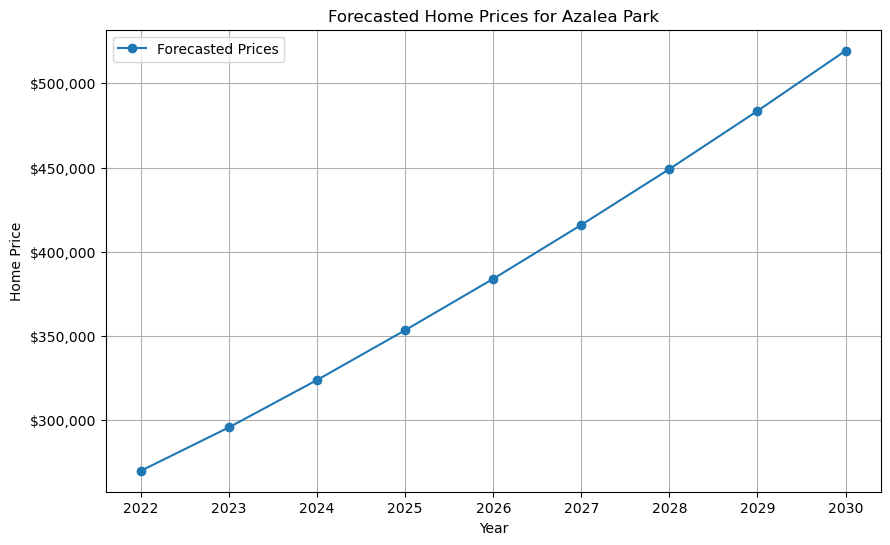

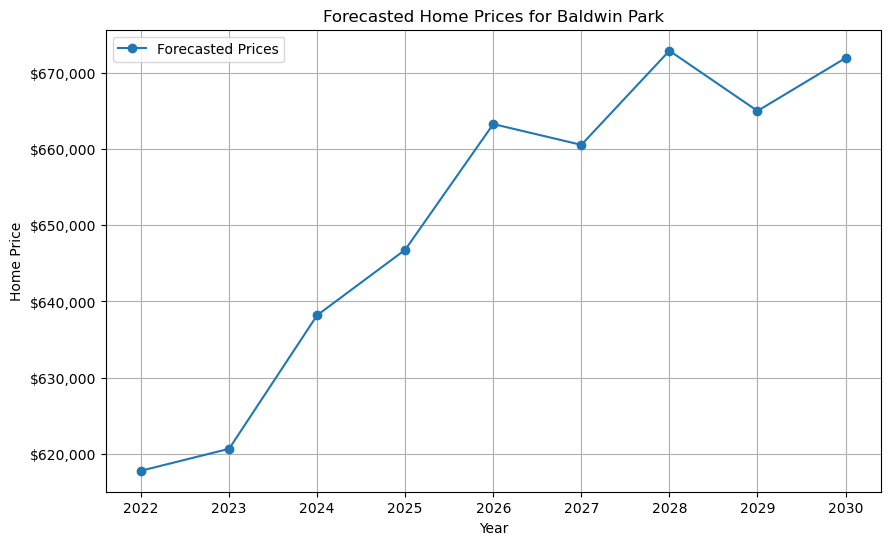

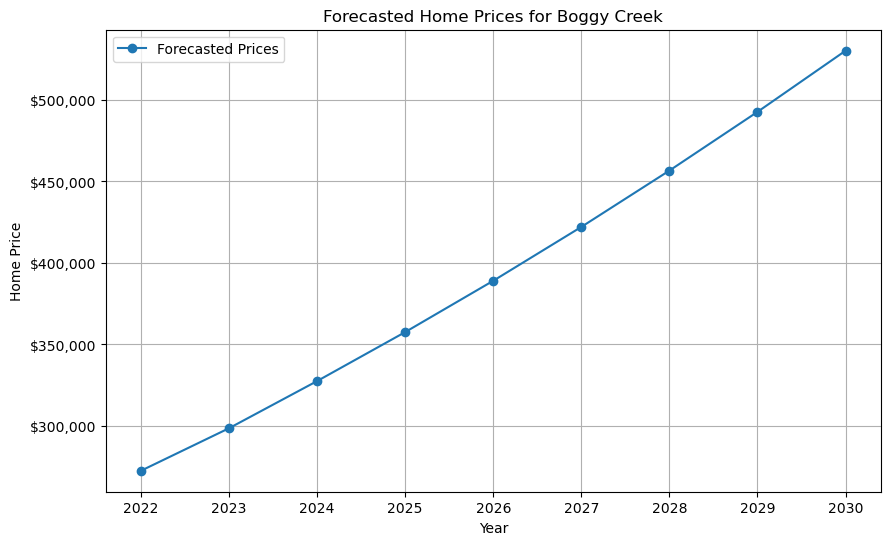

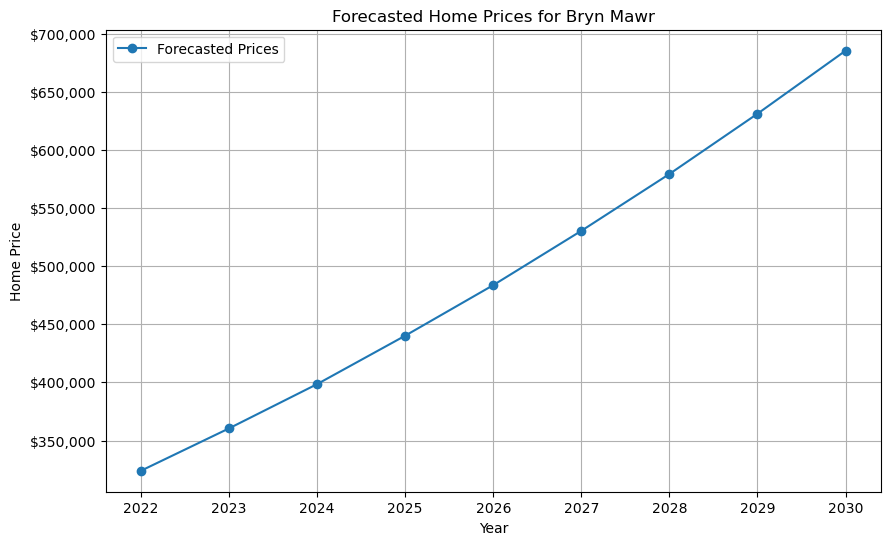

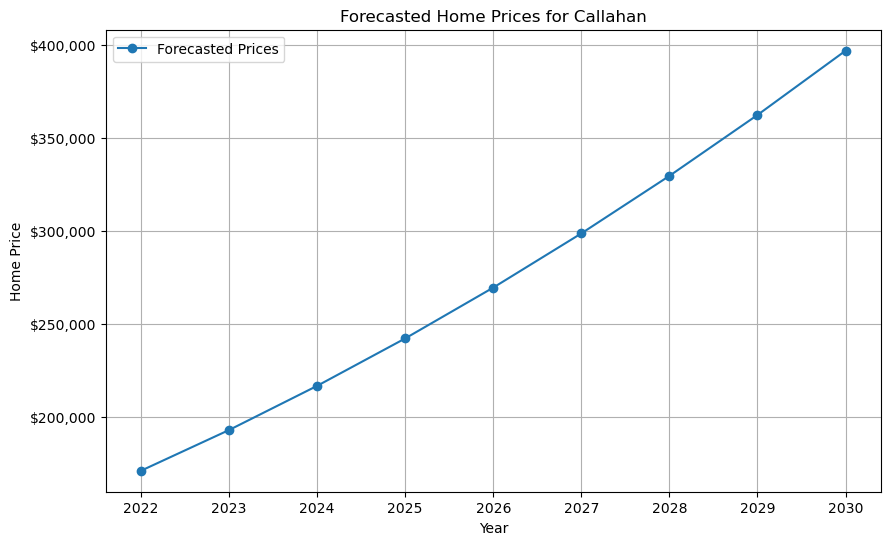

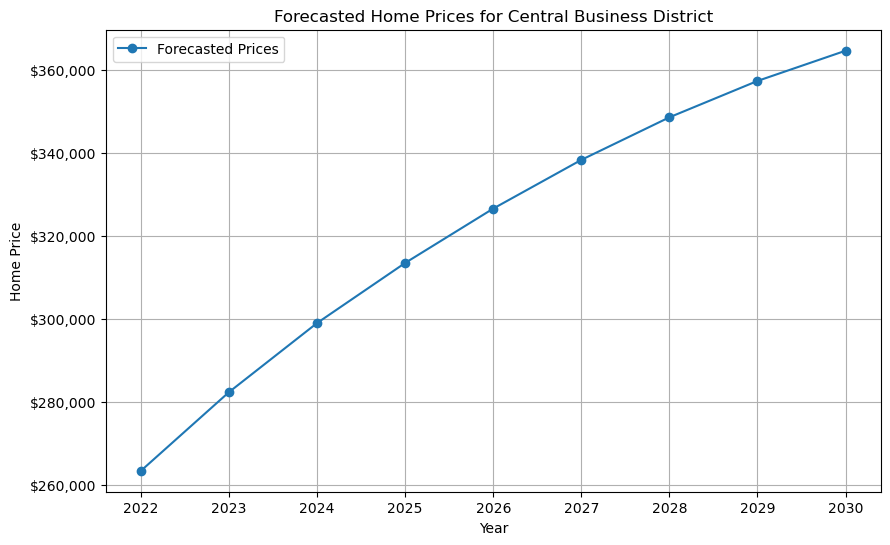

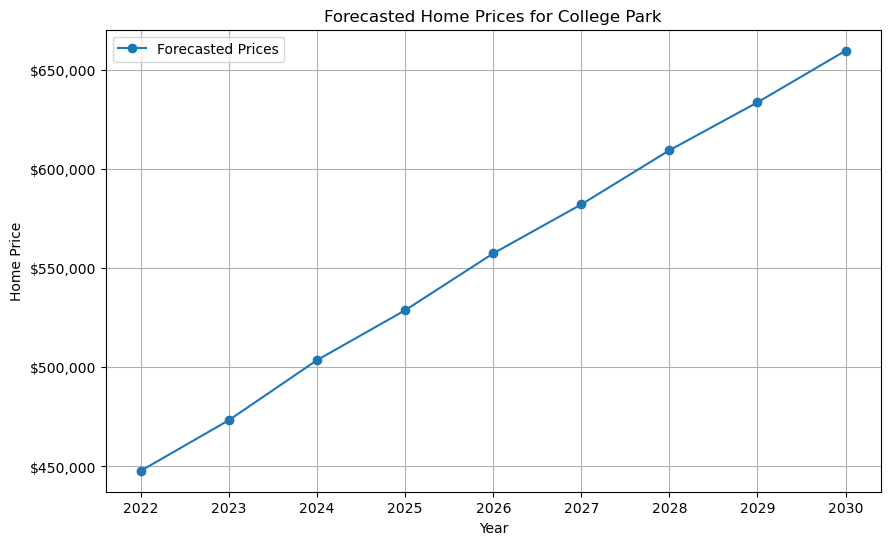

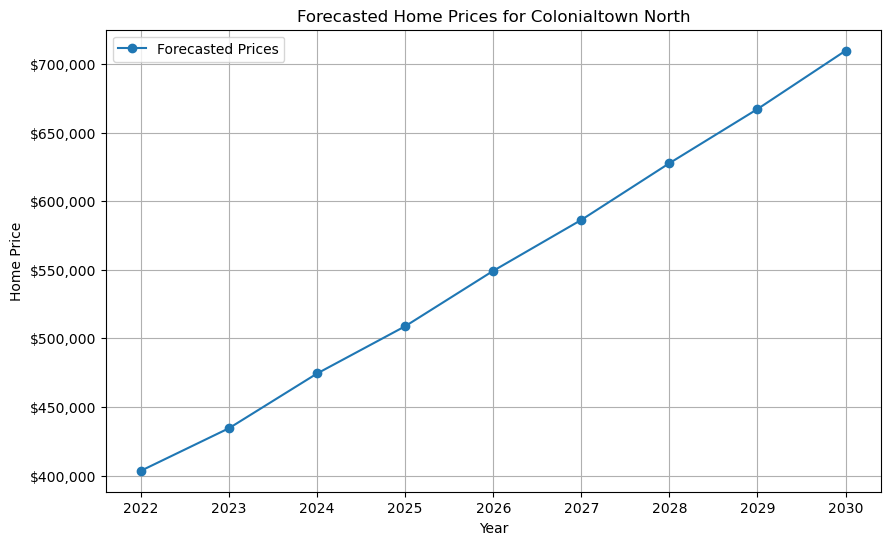

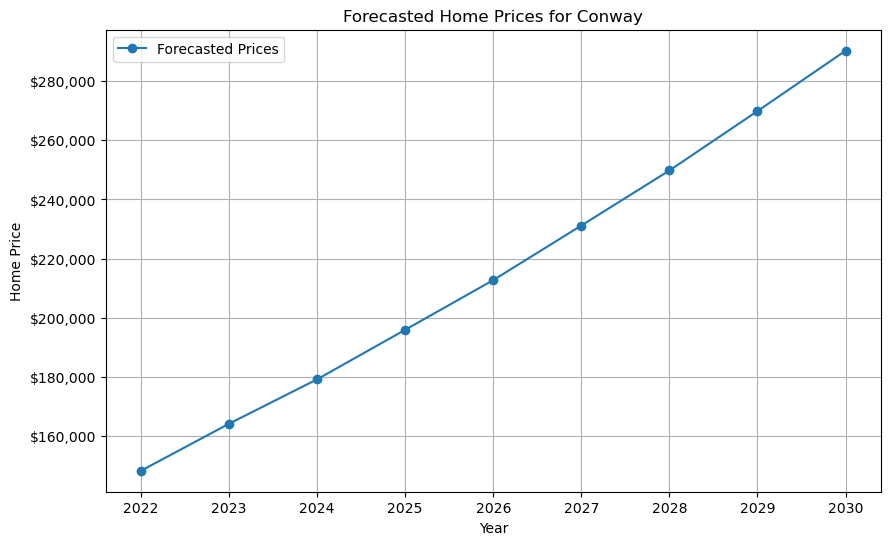

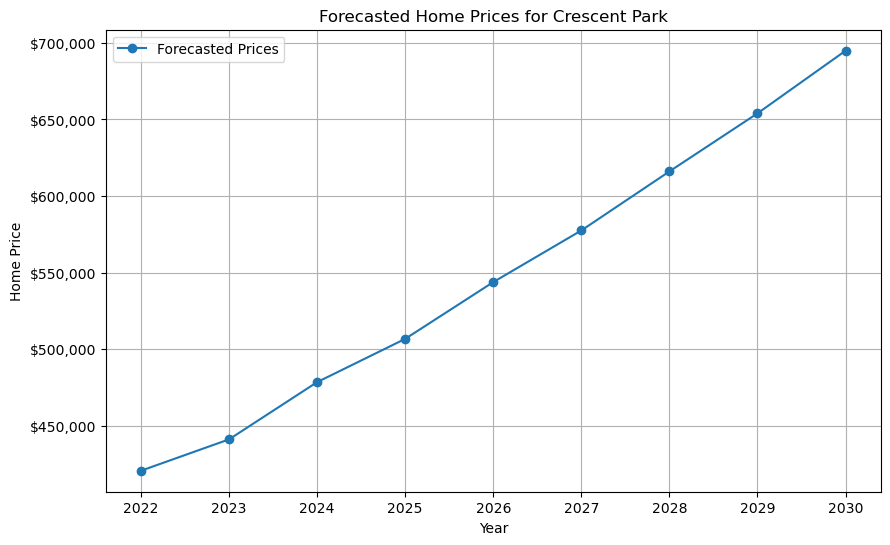

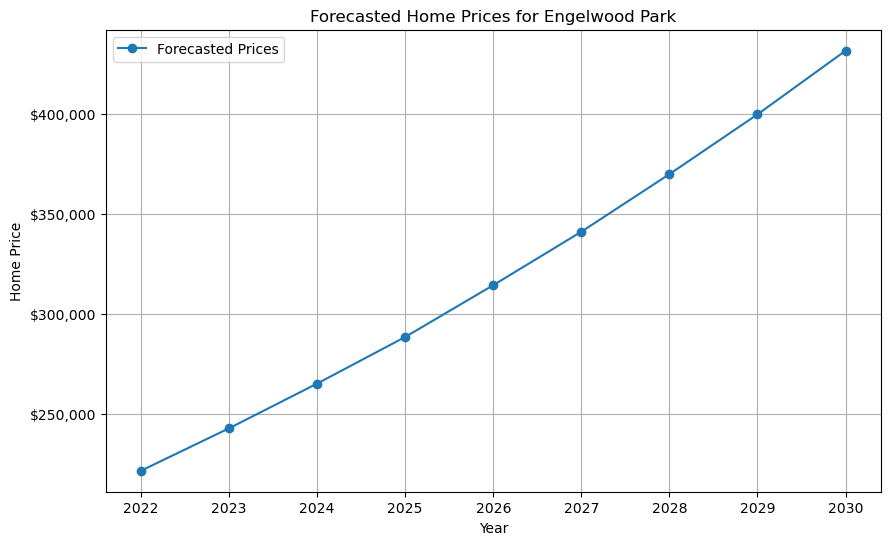

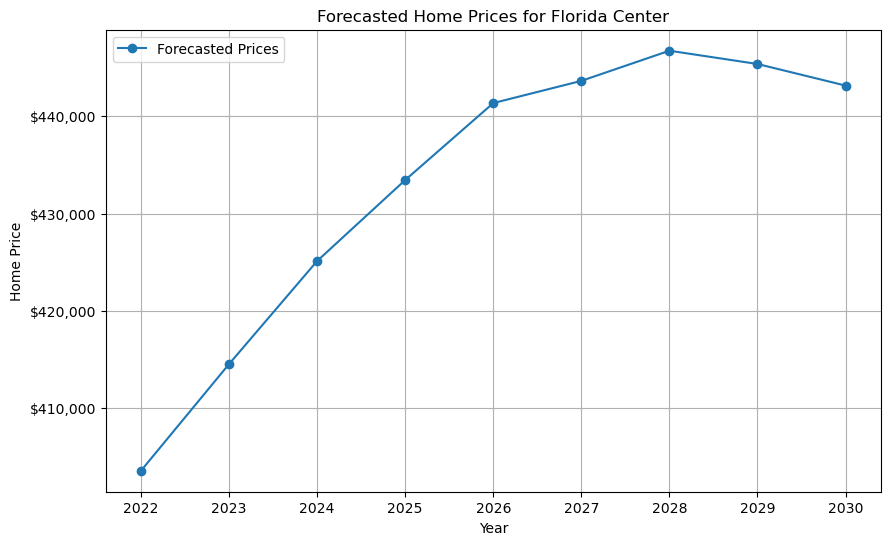

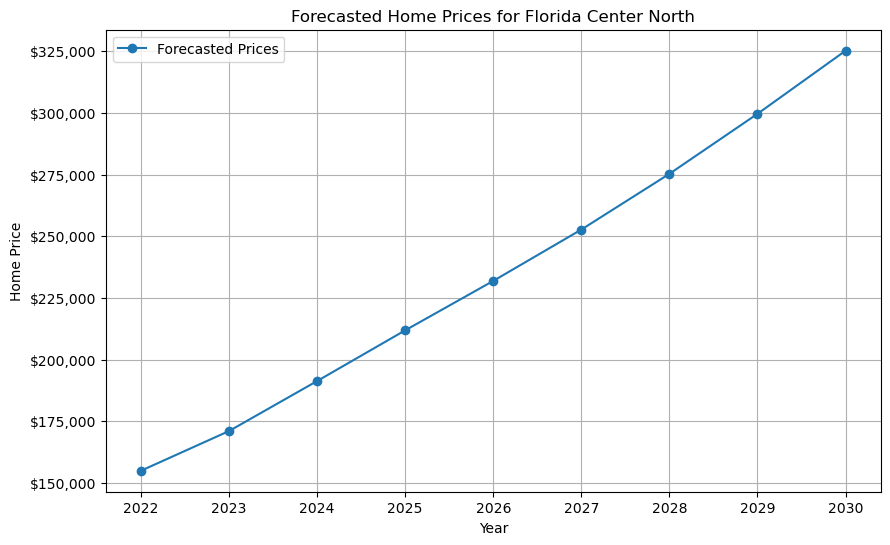

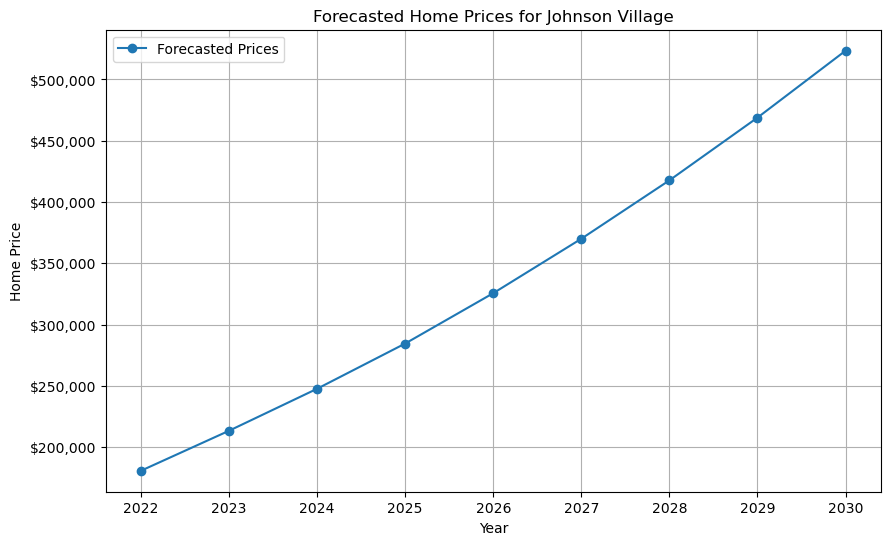

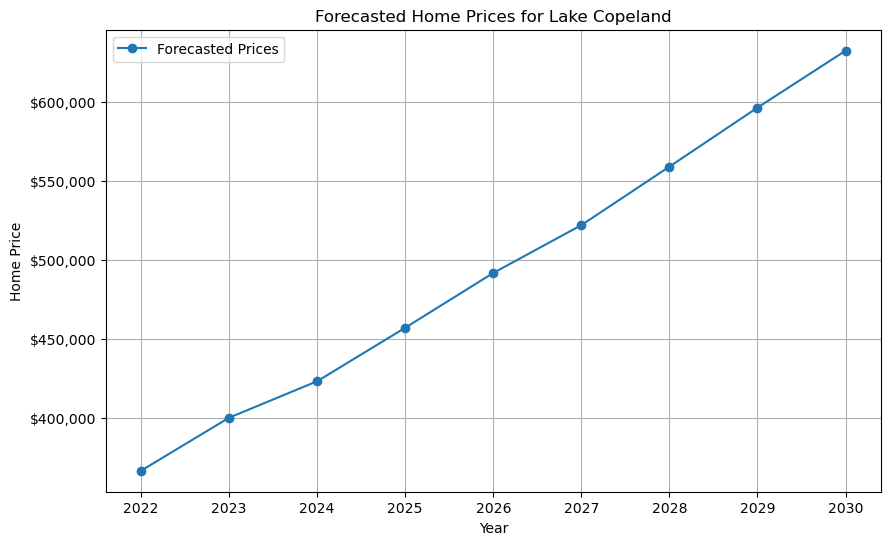

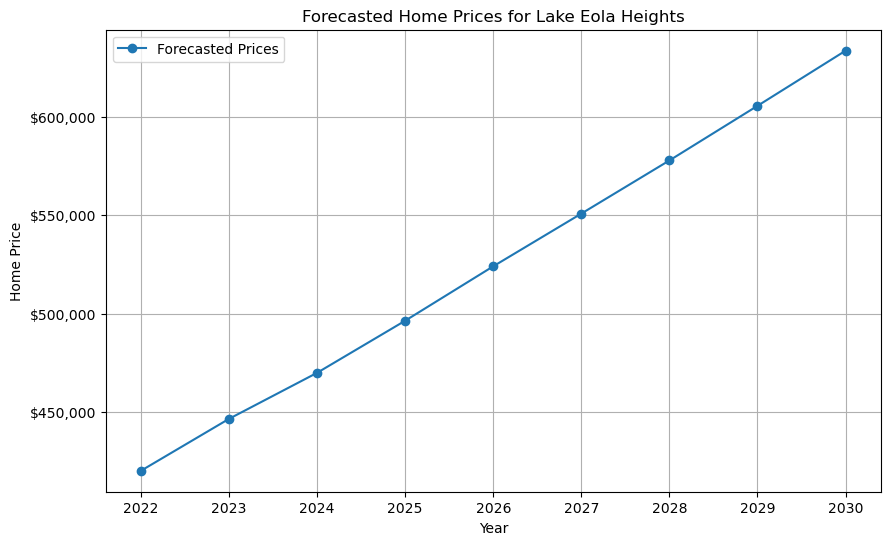

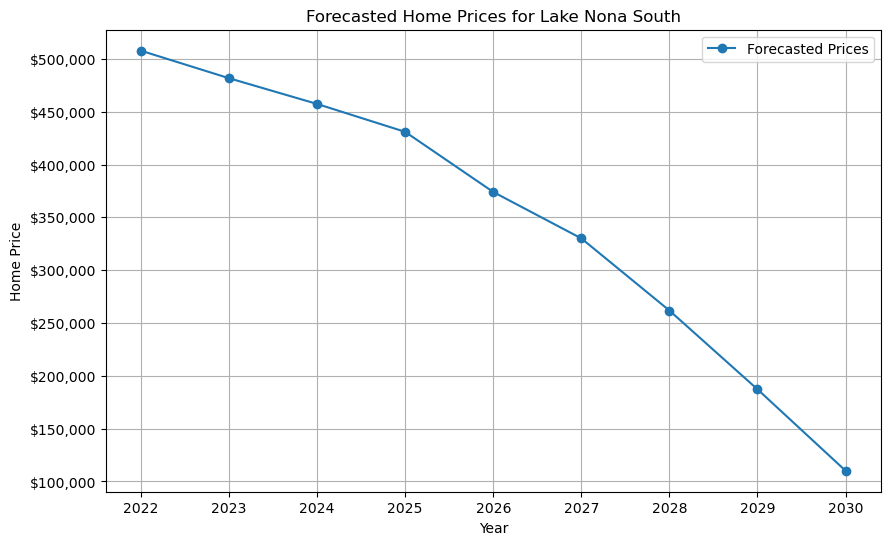

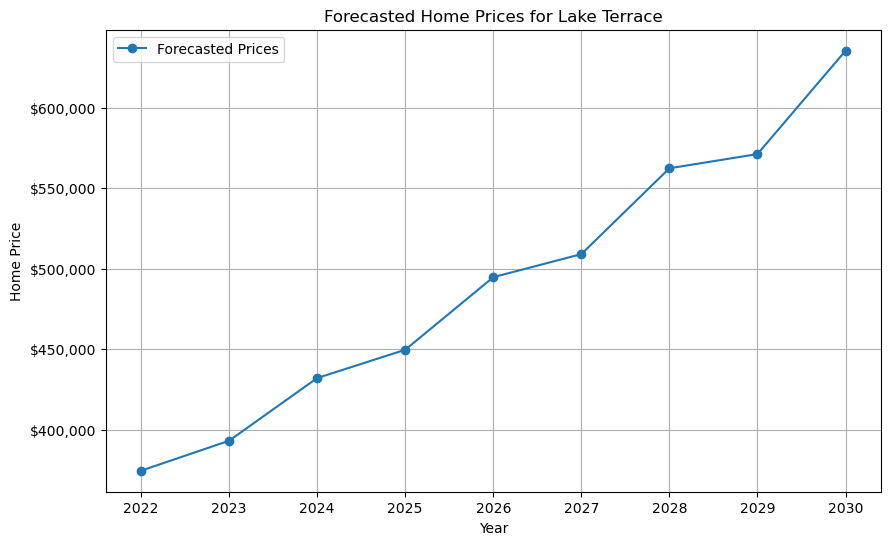

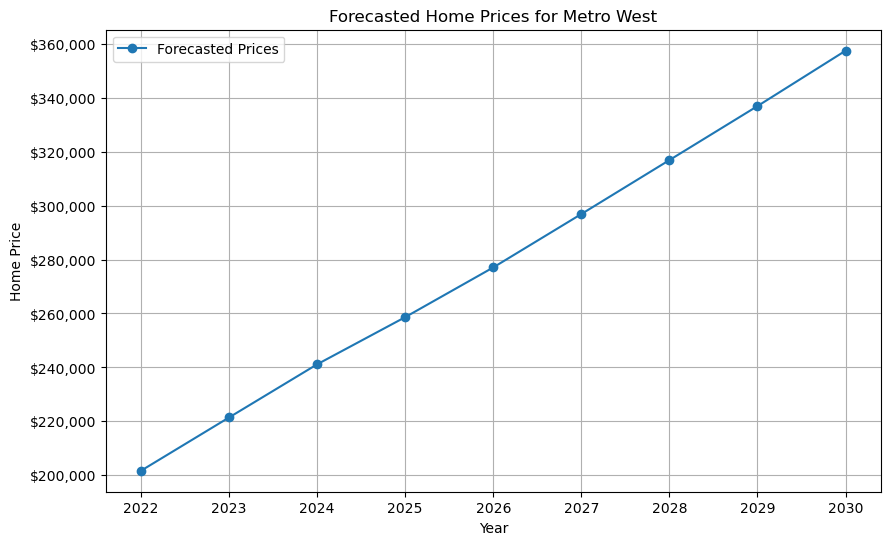

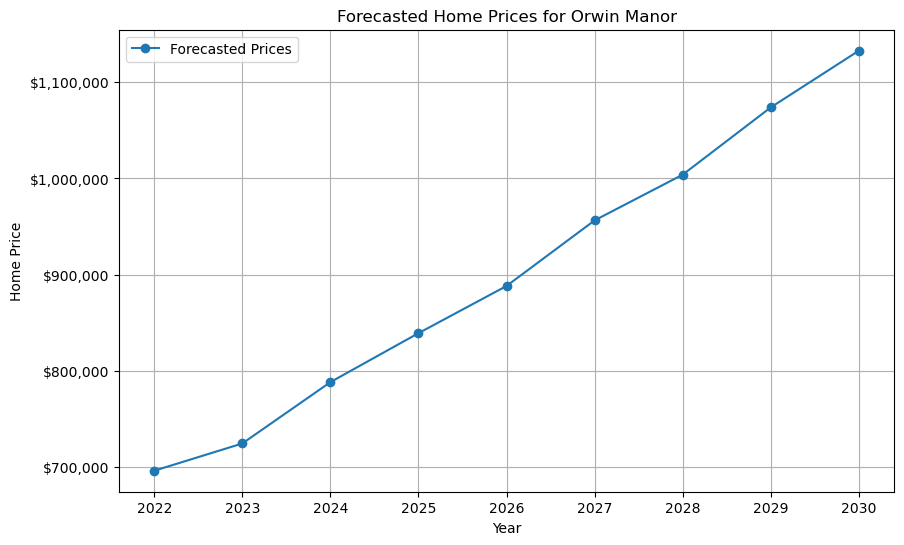

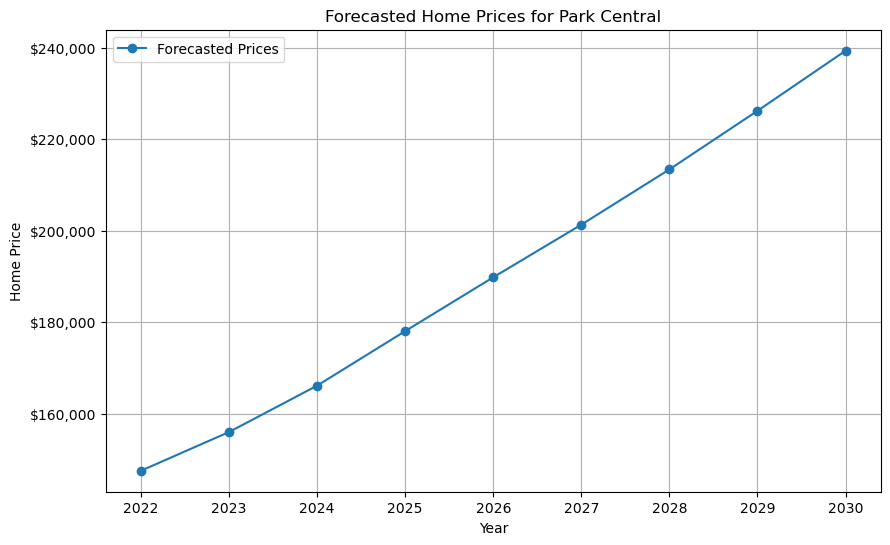

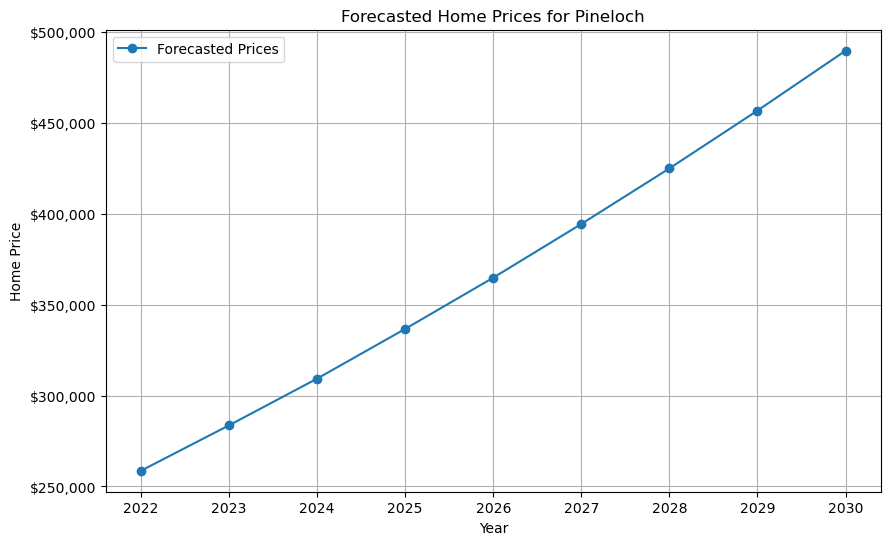

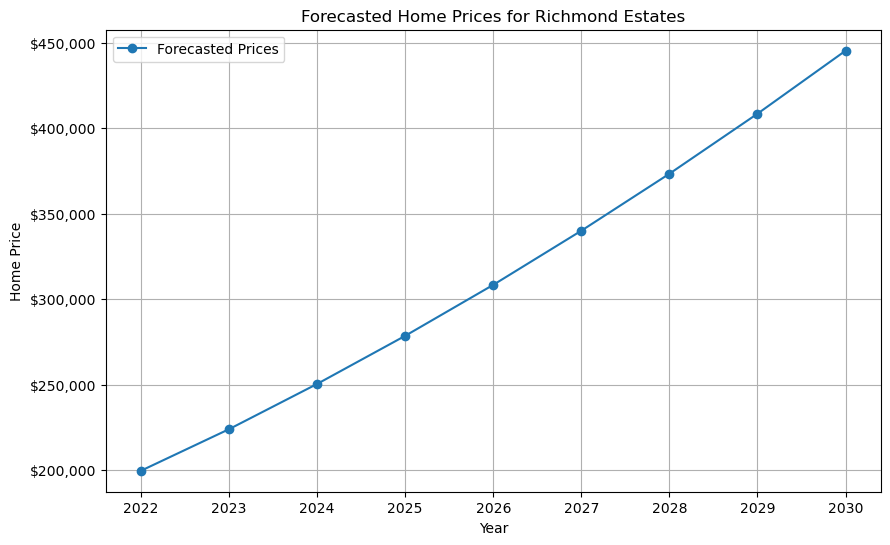

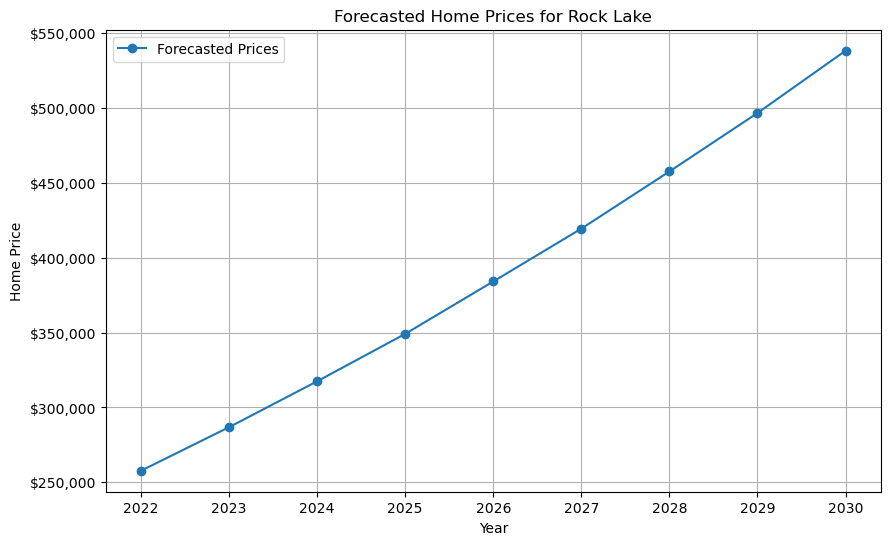

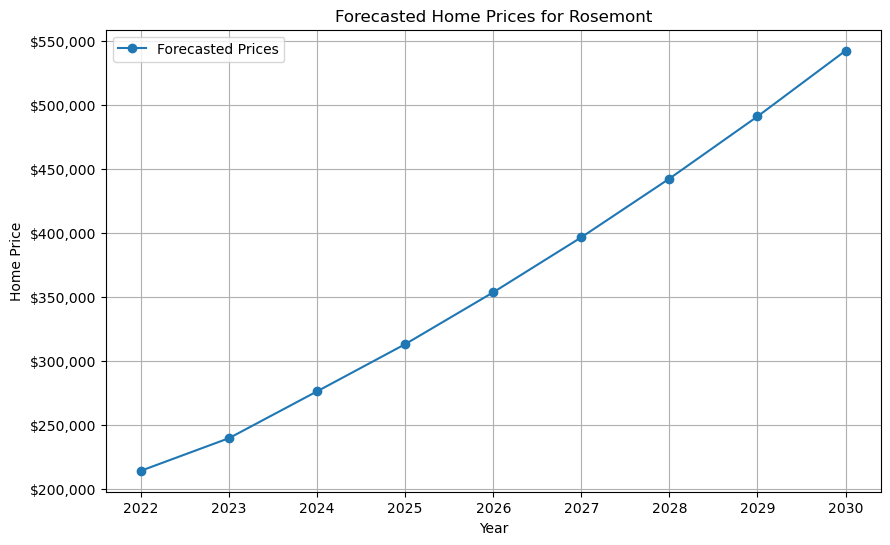

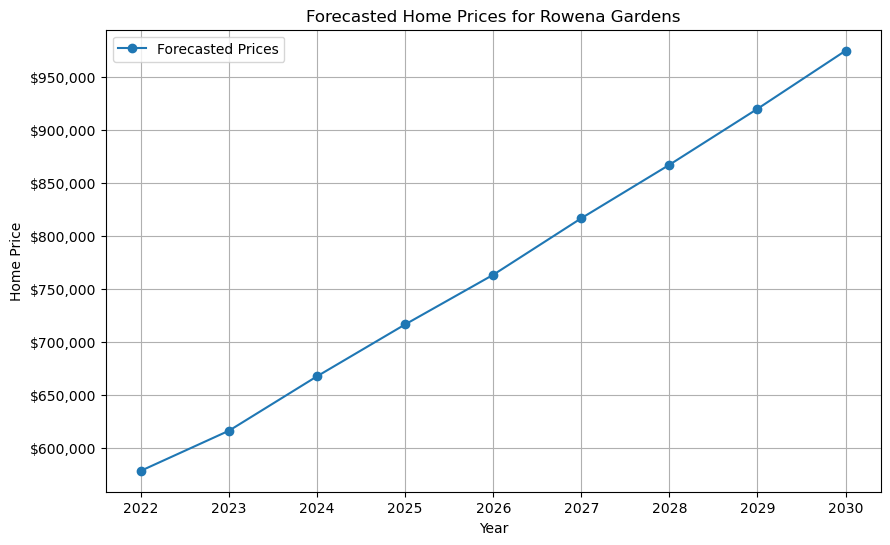

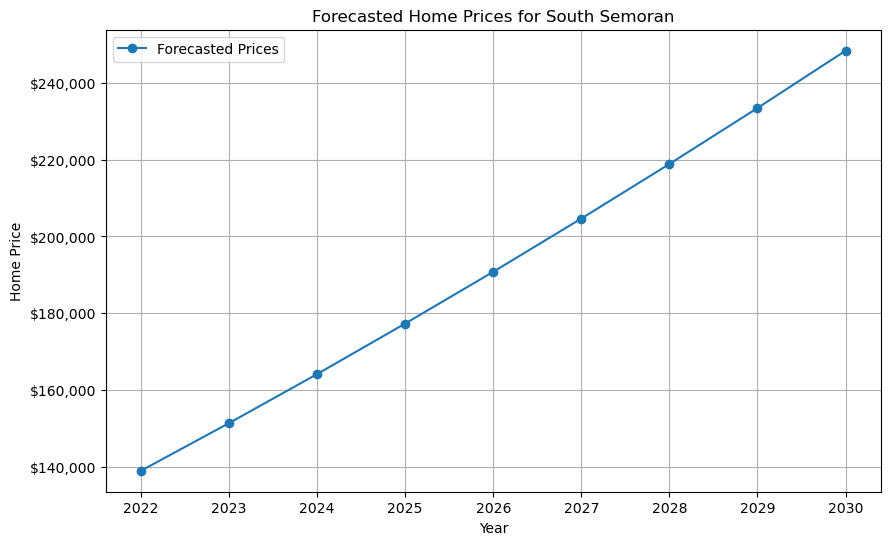

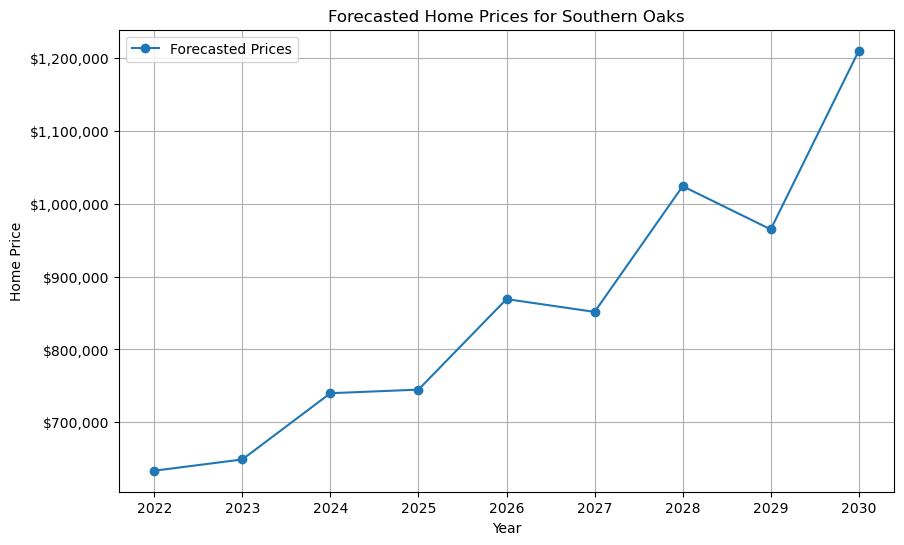

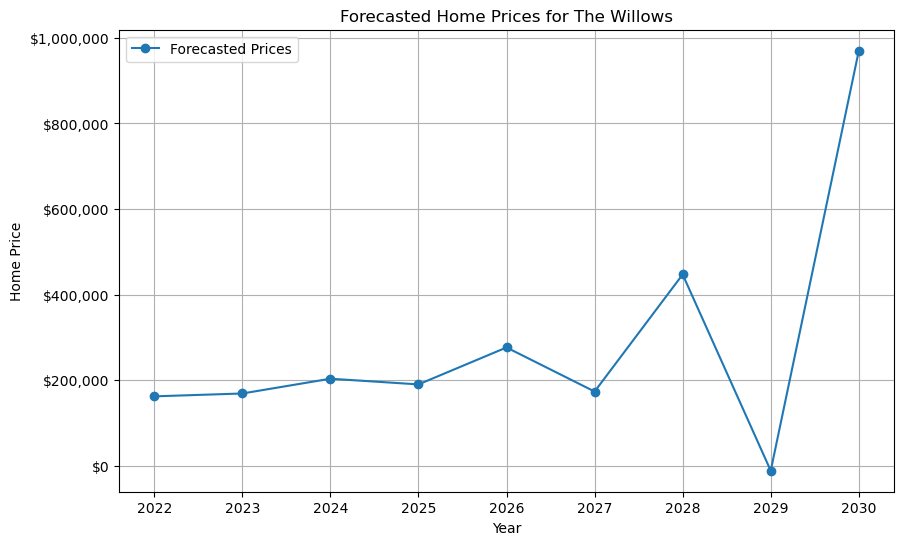

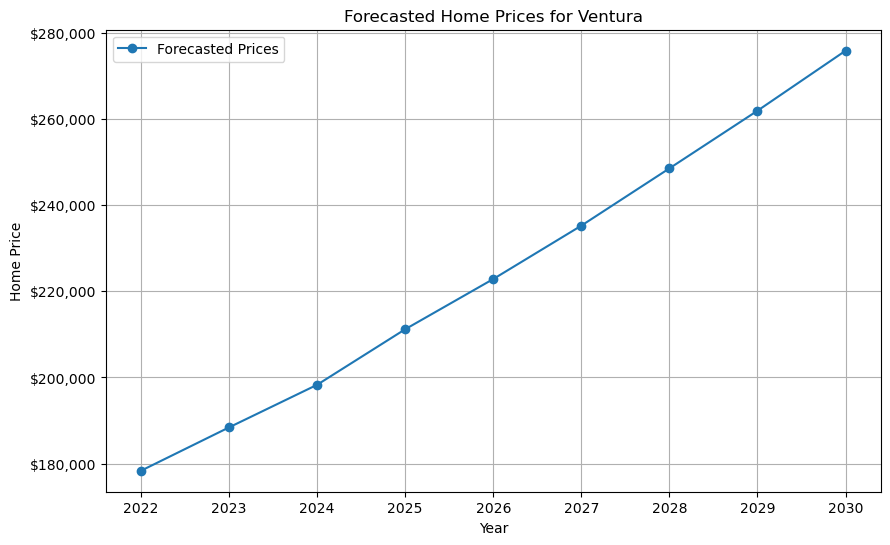

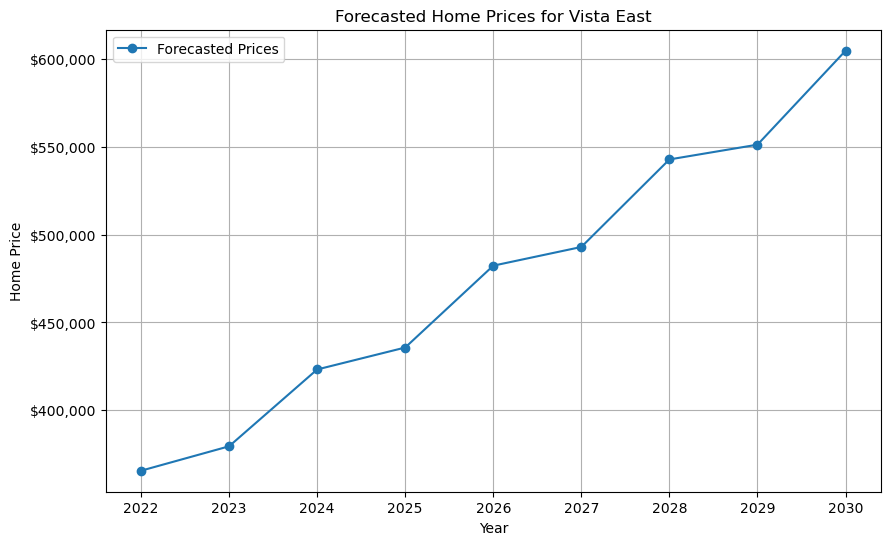

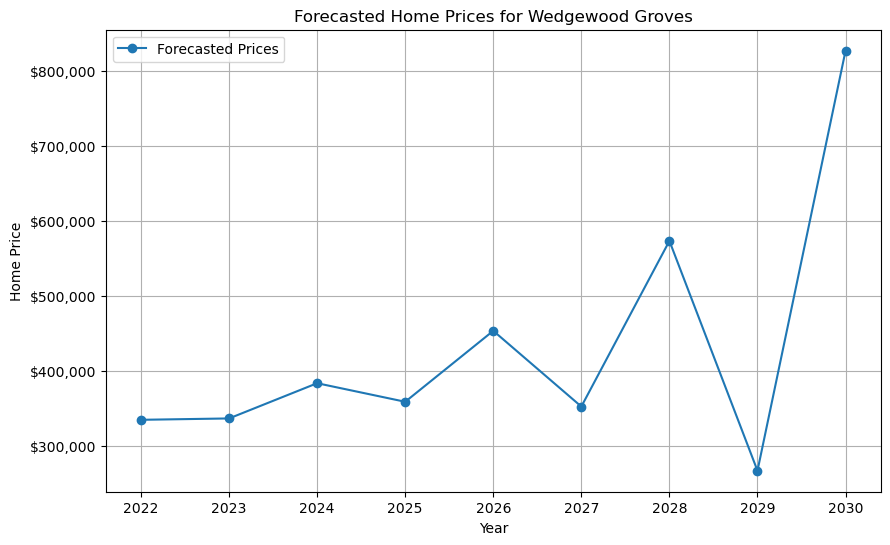

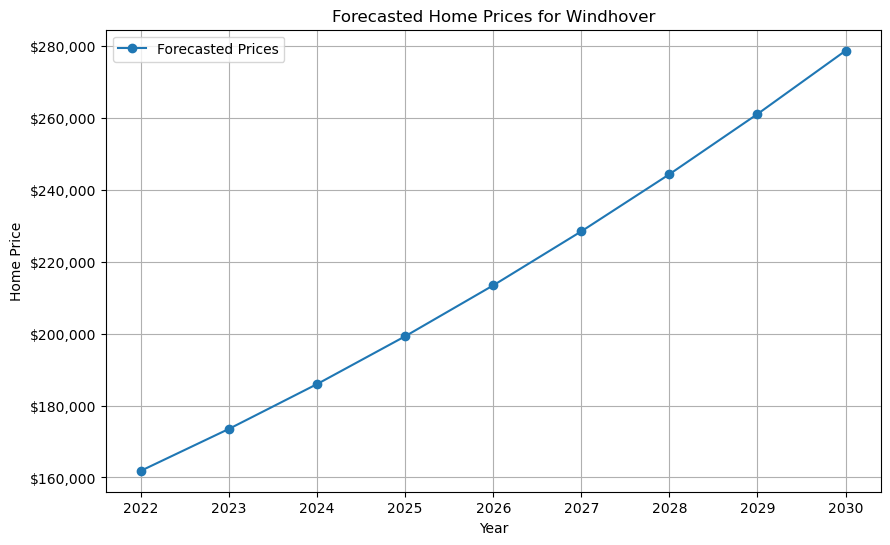

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot the forecasted home prices for each neighborhood
for neighborhood in forecast_horizon_df.index:
  plt.figure(figsize=(10, 6))
  plt.plot(forecast_horizon_df.columns, forecast_horizon_df.loc[neighborhood], marker='o', label='Forecasted Prices')
  plt.title(f'Forecasted Home Prices for {neighborhood}')
  plt.xlabel('Year')
  plt.ylabel('Home Price')
  plt.grid(True)
  plt.legend()

  # Format y-axis in dollars
  ax = plt.gca()
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

  plt.show()

In [22]:
# Calculate the CAGR for each neighborhood from 2025 to 2030
cagr_df = ((forecast_horizon_df[2030] / forecast_horizon_df[2025]) ** (1 / 5) - 1) * 100

# Convert the result to a DataFrame for better readability
cagr_df = cagr_df.to_frame(name='CAGR_2025_2030 (%)')

# Display the top 10 neighborhoods with the highest CAGR
print(cagr_df.sort_values(by='CAGR_2025_2030 (%)', ascending=False).head(10))

                      CAGR_2025_2030 (%)
The Willows                    38.494946
Wedgewood Groves               18.142800
Johnson Village                12.961169
Rosemont                       11.612801
Callahan                       10.362554
Southern Oaks                  10.200847
Richmond Estates                9.838901
Bryn Mawr                       9.257096
Rock Lake                       9.037051
Florida Center North            8.948221


## Prophet

In [ ]:
from prophet import Prophet

forecast_results_prophet = {}

# Iterate through each neighborhood and its Prophet model in df_prophet
for _, row in df_prophet.iterrows():
  neighborhood = row['neighborhood']
  model = row['value']  # Prophet model object

  # Create a future dataframe for the next 9 years (2022 to 2030 inclusive)
  future = model.make_future_dataframe(periods=9, freq='Y')

  # Generate the forecast
  forecast = model.predict(future)

  # Filter the forecast to include only the years 2022 to 2030
  forecast_filtered = forecast[forecast['ds'].dt.year.isin(range(2022, 2031))]

  # Store the forecasted values in the results dictionary
  forecast_results_prophet[neighborhood] = forecast_filtered[['ds', 'yhat']]

# Display the forecast results for the first neighborhood as an example
print(forecast_results_prophet[next(iter(forecast_results_prophet))])


c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = 

            ds           yhat
264 2022-01-31  234258.758688
265 2022-02-28  235758.803002
266 2022-03-31  238142.657089
267 2022-04-30  240465.448180
268 2022-05-31  242600.253705
269 2022-06-30  244709.133252
270 2022-07-31  246952.584502
271 2022-08-31  248868.908007
272 2022-09-30  250835.353698
273 2022-10-31  252738.661162
274 2022-11-30  254723.896148
275 2022-12-31  256712.269807
276 2023-12-31  280308.125436
277 2024-12-31  302357.981006
278 2025-12-31  325973.219929
279 2026-12-31  349578.994749
280 2027-12-31  373174.850379
281 2028-12-31  395224.705948
282 2029-12-31  418839.944871
283 2030-12-31  442445.719692


c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [25]:
# Reshape the forecast_results_prophet dictionary into a DataFrame
prophet_forecast_df = pd.DataFrame({
  neighborhood: forecast.set_index('ds')['yhat']
  for neighborhood, forecast in forecast_results_prophet.items()
})

# Transpose the DataFrame so that each neighborhood is an observation and each column is a year
prophet_forecast_df = prophet_forecast_df.T

# Rename columns to only include the year
prophet_forecast_df.columns = prophet_forecast_df.columns.year

# Display the cleaned-up DataFrame
print(prophet_forecast_df.head())

ds                      2022           2022           2022           2022  \
Airport North  234258.758688  235758.803002  238142.657089  240465.448180   
Alafaya        381812.490832  384086.179145  386904.986948  389629.955816   
Audubon Park   398291.896460  401107.830886  404604.215859  407921.629167   
Azalea Park    263853.210609  265917.167105  268474.195872  270906.132460   
Baldwin Park   618035.142844  620793.368667  624889.313982  628763.506697   

ds                      2022           2022           2022           2022  \
Airport North  242600.253705  244709.133252  246952.584502  248868.908007   
Alafaya        392275.437806  395158.879036  398132.015347  400709.443380   
Audubon Park   410872.193048  413769.078752  416375.067454  418655.442112   
Azalea Park    273126.871526  275427.013929  277646.796013  279692.959439   
Baldwin Park   632491.586815  636449.986702  640234.192781  643186.910732   

ds                      2022           2022           2022           2022 

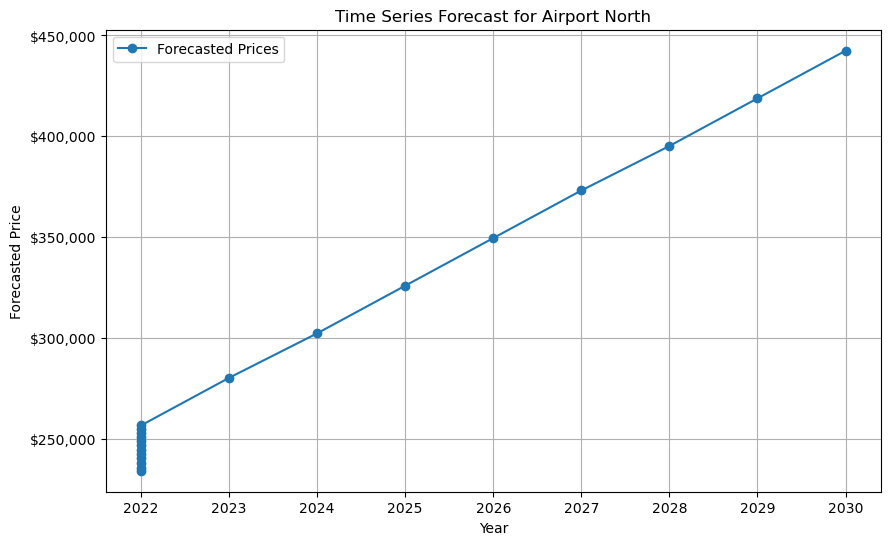

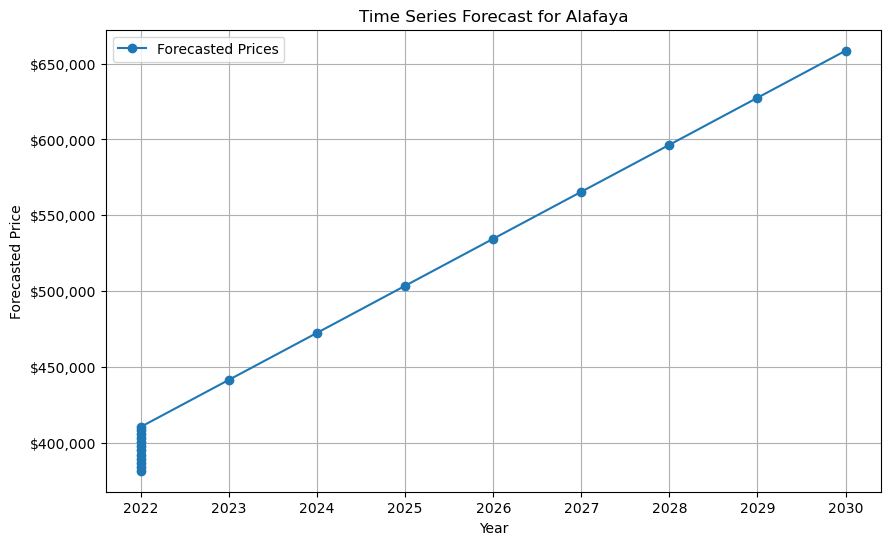

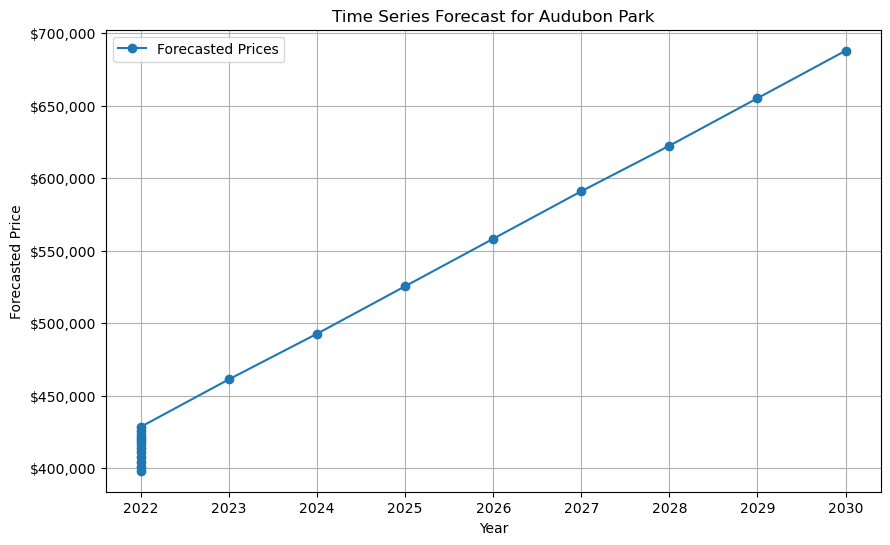

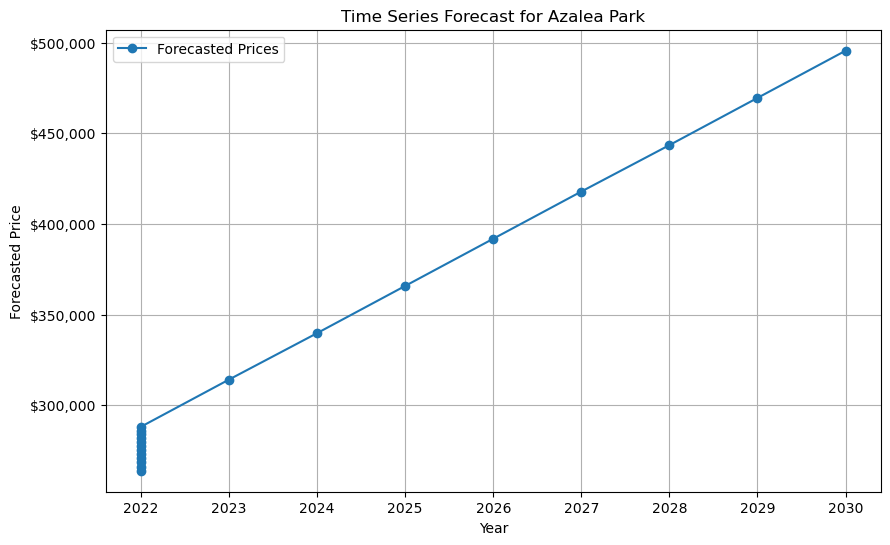

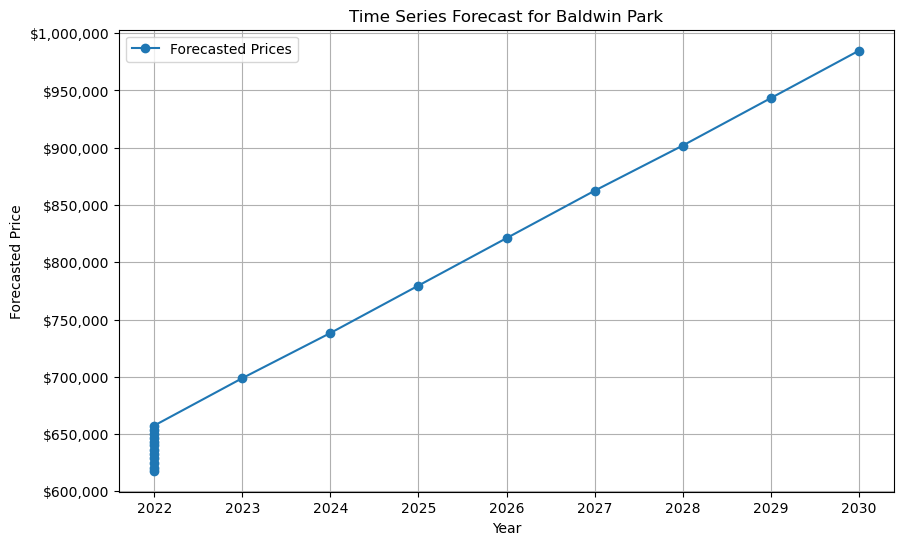

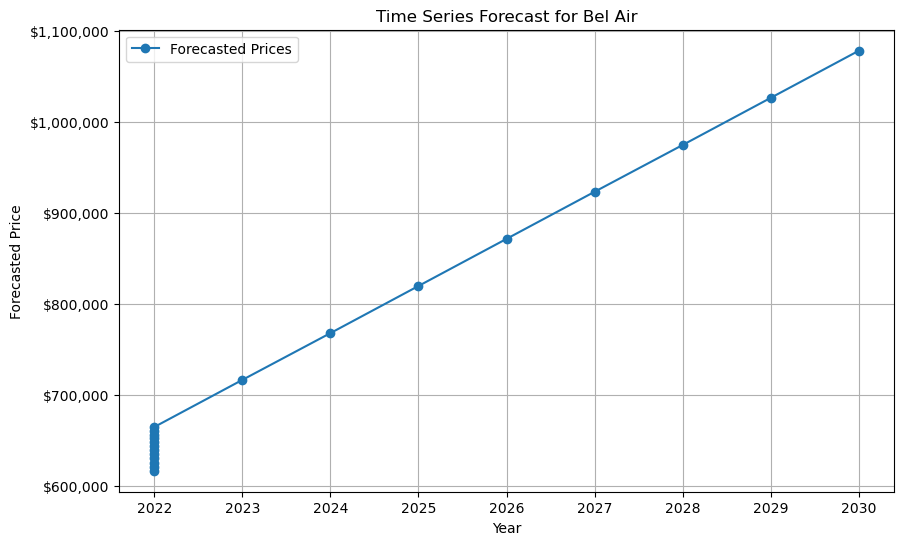

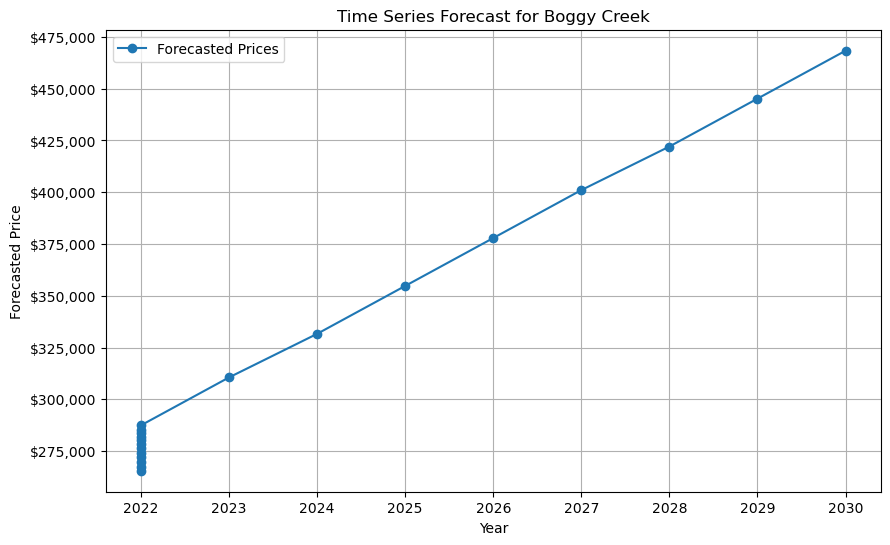

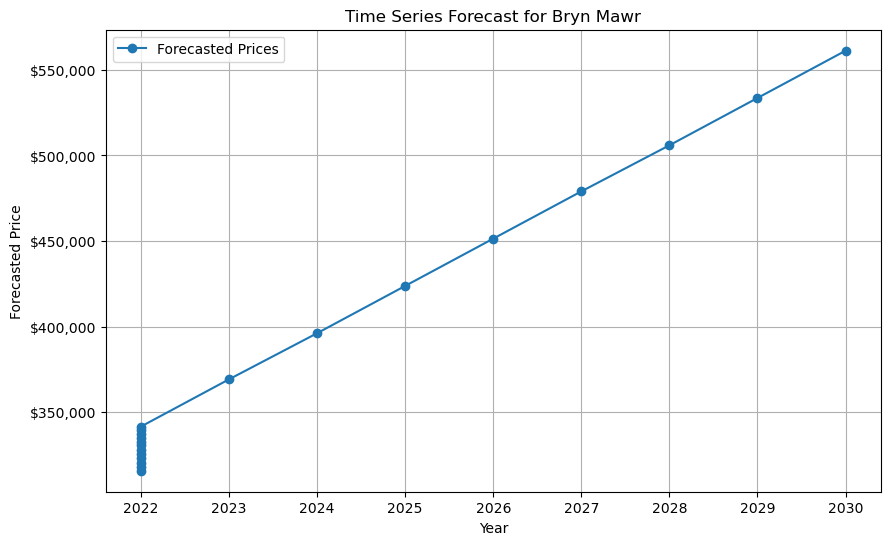

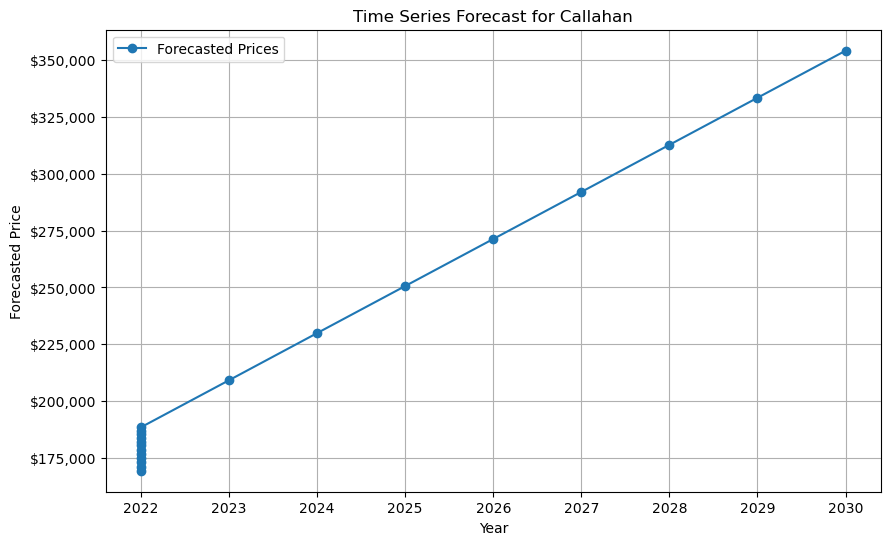

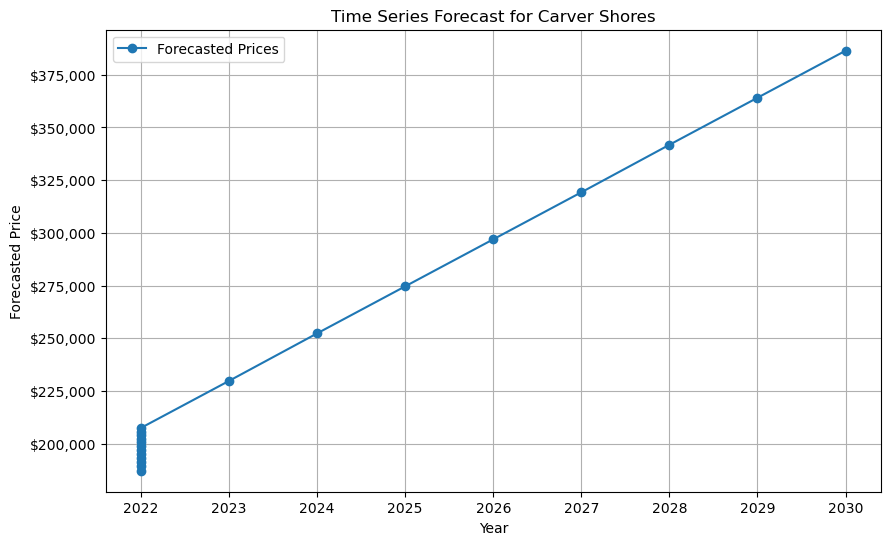

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot the time series for the first 10 neighborhoods
for neighborhood in prophet_forecast_df.index[:10]:
  plt.figure(figsize=(10, 6))
  plt.plot(prophet_forecast_df.columns, prophet_forecast_df.loc[neighborhood], marker='o', label='Forecasted Prices')
  plt.title(f'Time Series Forecast for {neighborhood}')
  plt.xlabel('Year')
  plt.ylabel('Forecasted Price')
  plt.grid(True)
  plt.legend()

  # Format y-axis in dollars and remove scientific notation
  ax = plt.gca()
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

  plt.show()

In [29]:
# Calculate the CAGR for each neighborhood from 2025 to 2030
cagr_df_prophet = ((prophet_forecast_df[2030] / prophet_forecast_df[2025]) ** (1 / 5) - 1) * 100

# Convert the result to a DataFrame for better readability
cagr_df_prophet = cagr_df_prophet.to_frame(name='CAGR_2025_2030 (%)')

# Display the top 10 neighborhoods with the highest CAGR
print(cagr_df_prophet.sort_values(by='CAGR_2025_2030 (%)', ascending=False).head(10))

                      CAGR_2025_2030 (%)
City of Orlando-GOAA           10.516155
Randal Park                     9.911813
The Willows                     9.503046
Williamsburg                    9.430433
Lake Nona South                 9.149937
Haralson Estates                8.675971
Lake Nona Central               8.176054
Lake Weldona                    7.932380
East Park                       7.715071
Lake Shore Village              7.686609
